In [1]:
import torch
import pandas as pd
from torch.utils.data import Dataset

In [2]:
PATH = "C:/Projects/TFM/dataset/AD_MCI_HC_WINDOWED"
INDEX_PATH = "C:/Projects/TFM/dataset/AD_MCI_HC_WINDOWED/data.csv"

In [3]:
from entities.graphs.graph_builder import RawAndPearson, MomentsAndPearson
from entities.graphs.data_reader import read_record

In [4]:
class BaseDataset(Dataset):
    def __init__(self, indices ,builder, transform=None, target_transform=None):
        self.indices = indices
        self.builder = builder
        self.transform = transform
        self.target_transform = target_transform
        
        

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        current_path = self.indices.iloc[idx]["path"]
        raw_data = read_record(current_path)
        label = self.indices.iloc[idx]["label"]
        data = self.builder.build(raw_data, label)
        
        return data

In [5]:
from sklearn.model_selection import train_test_split

indices = pd.read_csv(INDEX_PATH, index_col="Unnamed: 0")

indices = indices.drop(indices[indices.label == "MCI"].index)

indices_hc = indices[indices.label == 'HC'].sample(frac=0.4)
indices_ad = indices[indices.label == 'AD']
indices = pd.concat([indices_hc, indices_ad])

train_data, test_data = train_test_split(indices, shuffle=True)

builder = RawAndPearson(normalize_nodes=True, normalize_edges=True)
#builder = MomentsAndPearson()

train_dataset = BaseDataset(train_data, builder)
test_dataset = BaseDataset(test_data, builder)

#len(indices[indices.label == "HC"])
# MCI 4430 -> 2
# AD 2756 -> 0
# HC 6641 -> 1
train_data

,path,label
506,C:\Projects\TFM\dataset\AD_MCI_HC_WINDOWED\AD\...,AD
2407,C:\Projects\TFM\dataset\AD_MCI_HC_WINDOWED\AD\...,AD
8716,C:\Projects\TFM\dataset\AD_MCI_HC_WINDOWED\HC\...,HC
1979,C:\Projects\TFM\dataset\AD_MCI_HC_WINDOWED\AD\...,AD
8129,C:\Projects\TFM\dataset\AD_MCI_HC_WINDOWED\HC\...,HC
...,...,...
7024,C:\Projects\TFM\dataset\AD_MCI_HC_WINDOWED\HC\...,HC
835,C:\Projects\TFM\dataset\AD_MCI_HC_WINDOWED\AD\...,AD
8374,C:\Projects\TFM\dataset\AD_MCI_HC_WINDOWED\HC\...,HC
231,C:\Projects\TFM\dataset\AD_MCI_HC_WINDOWED\AD\...,AD


In [6]:
def check_class_weights():
    class_counts = counts
    numDataPoints = class_counts.sum()


    target = torch.cat((torch.zeros(class_counts[0], dtype=torch.long),
                        torch.ones(class_counts[1], dtype=torch.long),
                        torch.ones(class_counts[2], dtype=torch.long) * 2))

    print('target train 0/1/2: {}/{}/{}'.format(
        (target == 0).sum(), (target == 1).sum(), (target == 2).sum()))

    # Compute samples weight (each sample should get its own weight)
    class_sample_count = torch.tensor(
        [(target == t).sum() for t in torch.unique(target, sorted=True)])
    weight = 1. / class_sample_count.float()
    samples_weight = torch.tensor([weight[t] for t in target])

    # Create sampler, dataset, loader
    sampler = WeightedRandomSampler(samples_weight, len(samples_weight))

    #train_dataset = torch.utils.data.TensorDataset(data, target)
    #train_dataset = triaxial_dataset(data, target)

    # Iterate DataLoader and check class balance for each batch
    for i, (data) in enumerate(train_dataloader):
        print("batch index {}, 0/1/2: {}/{}/{}".format(
            i, (data.label == 0).sum(), (data.label == 1).sum(), (data.label == 2).sum()))

In [7]:
from torch_geometric.loader import DataLoader

_BATCH_SIZE = 256
train_dataloader = DataLoader(train_dataset, batch_size=_BATCH_SIZE, shuffle=True)#sampler=weighted_sampler)
test_dataloader = DataLoader(test_dataset, batch_size=_BATCH_SIZE, shuffle=True)

In [8]:
def check_data():
    for data in train_dataloader:
        print(data[0].edge_attr)
        print(next(iter(data[0]))[1].shape)
        break

check_data()

TypeError: extract_features() got an unexpected keyword argument 'normalize'

In [10]:
from entities.models.factory import ModelFactory
from entities.models.modelsTypes import Model

model_factory = ModelFactory()
model = model_factory.create(Model.EEGGRAPHCONVNET)
model = model.double()

In [11]:
model

EEGGraphConvNet(
  (conv1): GCNConv(6, 16)
  (conv2): GCNConv(16, 32)
  (conv3): GCNConv(32, 64)
  (conv4): GCNConv(64, 50)
  (batch_norm): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=50, out_features=30, bias=True)
  (fc2): Linear(in_features=30, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=2, bias=True)
)

In [24]:
criterion = torch.nn.CrossEntropyLoss()#weight=torch.tensor([3, 1], dtype=torch.float64)) 
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

In [25]:
from sklearn.metrics import roc_auc_score, balanced_accuracy_score
from numpy import mean

auroc_train_history = []
auroc_test_history = []
balACC_train_history = []

balACC_test_history = []
loss_train_history = []
loss_test_history = []

train_accs = []
test_accs = []

_NUM_EPOCHS = 1000
_DEVICE = torch.device("cpu")


def train():
    model.train()
    running_loss = 0.0
    batch_loss = []
    for i, data in enumerate(train_dataloader):  # Iterate in batches over the training dataset.

        data.batch = data.batch.view(data.batch.shape[0], -1)
        
        out = model(data.x, data.edge_index, data.edge_attr,
                    data.batch)  # Perform a single forward pass.
        
        

        loss = criterion(out, data.label)  # Compute the loss.
        #print(loss.item())
        batch_loss.append(loss.item())
        #print(data.label)
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.
        
        running_loss += loss.item()
        if i%100 == 99:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}')
            running_loss = 0.0
    print(f"Training epoch {epoch}: {mean(batch_loss):.3f} loss")
    scheduler.step()

def test(loader):
    model.eval()

    correct = 0
    y_probs_train = torch.empty(0, 2).to(_DEVICE)
    y_true_train, y_pred_train = [], []
    with torch.no_grad():
        for data in loader:  # Iterate in batches over the training/test dataset.
            out = model(data.x, data.edge_index, data.edge_attr, data.batch)
            y_batch = data.label.to(device=_DEVICE, non_blocking=True)
            
            pred = out.argmax(dim=1)  # Use the class with highest probability.
            
            #print(pred)
            
            correct += int((pred == data.label).sum())  # Check against ground-truth labels.
            y_pred_train += pred.cpu().numpy().tolist()
            
            y_probs_train = torch.cat((y_probs_train, out.data), 0)
            y_true_train += y_batch.cpu().numpy().tolist()
            
    y_probs_train = torch.nn.functional.softmax(y_probs_train, dim=1).cpu().numpy()
    y_true_train = np.array(y_true_train)

    return correct / len(loader.dataset), y_true_train, y_probs_train, y_pred_train  # Derive ratio of correct predictions.


for epoch in range(_NUM_EPOCHS):
    train()
    
    train_acc, y_true_train, y_probs_train, y_pred_train = test(train_dataloader)
    test_acc, y_true_test, y_probs_test, y_pred_test = test(test_dataloader)
    train_accs.append(train_acc)
    test_accs.append(test_acc)

    balACC_train_history.append(balanced_accuracy_score(y_true_train, y_pred_train))
    balACC_test_history.append(balanced_accuracy_score(y_true_test, y_pred_test))

    print("Train Bal.ACC: {}, test Bal.ACC: {}".format(balACC_train_history[-1], balACC_test_history[-1]))
    
    
    print(
        f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}'
    )

Training epoch 0: 0.694 loss
Train Bal.ACC: 0.5688278343846029, test Bal.ACC: 0.5654058003597122
Epoch: 000, Train Acc: 0.5620, Test Acc: 0.5558
Training epoch 1: 0.696 loss
Train Bal.ACC: 0.5718030621596852, test Bal.ACC: 0.5693738758992806
Epoch: 001, Train Acc: 0.5648, Test Acc: 0.5596
Training epoch 2: 0.702 loss
Train Bal.ACC: 0.5009704027171276, test Bal.ACC: 0.5035971223021583
Epoch: 002, Train Acc: 0.4864, Test Acc: 0.4831
Training epoch 3: 0.695 loss
Train Bal.ACC: 0.5033683307276223, test Bal.ACC: 0.5044964028776978
Epoch: 003, Train Acc: 0.4901, Test Acc: 0.4861
Training epoch 4: 0.693 loss
Train Bal.ACC: 0.5759407515229932, test Bal.ACC: 0.5713916366906475
Epoch: 004, Train Acc: 0.5678, Test Acc: 0.5603
Training epoch 5: 0.694 loss
Train Bal.ACC: 0.5731676909806458, test Bal.ACC: 0.5698684802158274
Epoch: 005, Train Acc: 0.5658, Test Acc: 0.5596
Training epoch 6: 0.691 loss
Train Bal.ACC: 0.5716244811041027, test Bal.ACC: 0.5705260791366906
Epoch: 006, Train Acc: 0.5643, Te

KeyboardInterrupt: 

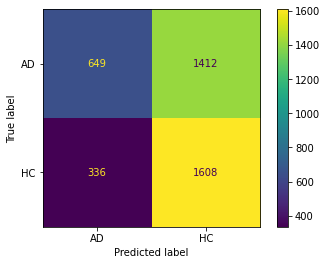

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true_train, y_pred_train)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["AD", "HC"])

disp.plot()

# Here starts the version using DGL

In [16]:
import dgl
from dgl.data import DGLDataset
    
# Source code from the paper, no changes made
class EEGGraphDataset(DGLDataset):
	def __init__(self, indices, builder, num_nodes):
		# CAUTION - x and labels are memory-mapped, used as if they are in RAM.
		self.num_nodes = num_nodes
		self.builder = builder
		self.indices = indices

	
    # returns size of dataset = number of indices
	def __len__(self):
		return len(self.indices)

	# retrieve one sample from the dataset after applying all transforms
	def __getitem__(self, idx):
		src = [[0 for i in range(self.num_nodes)] for j in range(self.num_nodes)]
		for i in range(len(src)):
			for j in range(len(src[i])):
				src[i][j] = i
		src = np.array(src).flatten()

		det = [[i for i in range(self.num_nodes)] for j in range(self.num_nodes)]
		det = np.array(det).flatten()

		u, v = (torch.tensor(src), torch.tensor(det))
		print(u)
		
		g = dgl.graph((u, v))

		current_path = self.indices.iloc[idx]["path"]
		raw_data = read_record(current_path)
		label = self.indices.iloc[idx]["label"]
		data = self.builder.build(raw_data, label)

		# add node features and edge features
		g.ndata['x'] = data.x
		g.edata['edge_weights'] = data.edge_attr
		label = data.label
		return g, torch.tensor(idx), torch.tensor(label)

In [17]:
from sklearn.model_selection import train_test_split

indices = pd.read_csv(INDEX_PATH, index_col="Unnamed: 0")
#indices = indices.drop(indices[indices.label == "MCI"].index)
train_data, test_data = train_test_split(indices)

builder = RawAndPearson()
#builder = MomentsAndPearson()

In [18]:
from torch.utils.data import WeightedRandomSampler
import numpy as np

labels_unique, counts = np.unique(indices["label"], return_counts=True)

class_weights = np.array([1.0 / x for x in counts])
# provide weights for samples in the training set only
weighted_sampler = WeightedRandomSampler(
    weights=class_weights,
    num_samples=len(train_data), replacement=True
)
print(len(train_dataset))
print(counts)
class_weights

4005
[2756 6461 4430]


array([0.00036284, 0.00015477, 0.00022573])

In [19]:
_BATCH_SIZE = 64
NUM_WORKERS = 0
PIN_MEMORY = True
_NUM_NODES = 19

from dgl.dataloading import GraphDataLoader

train_dataset = EEGGraphDataset(train_data, builder, _NUM_NODES)

test_dataset = EEGGraphDataset(test_data, builder, _NUM_NODES)

train_batches = GraphDataLoader(dataset=train_dataset,
                           batch_size=_BATCH_SIZE,
                           shuffle=False,
                           sampler=weighted_sampler,
                           num_workers=NUM_WORKERS,
                           pin_memory=PIN_MEMORY)

test_batches = GraphDataLoader(dataset=test_dataset,
                          batch_size=_BATCH_SIZE,
                          shuffle=False,
                          num_workers=NUM_WORKERS,
                          pin_memory=PIN_MEMORY)


train_metrics_loader = GraphDataLoader(
        dataset=test_dataset, batch_size=_BATCH_SIZE,
        shuffle=False, num_workers=NUM_WORKERS,
        pin_memory=True
    )

In [20]:
from entities.models.factory import ModelFactory
from entities.models.modelsTypes import Model

model_factory = ModelFactory()
model = model_factory.create(Model.EEGGRAPHCONVNET)
model = model.double()

In [21]:
criterion = torch.nn.CrossEntropyLoss() 
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[i * 10 for i in range(1, 26)], gamma=0.1)

In [22]:
from sklearn.metrics import roc_auc_score, balanced_accuracy_score


num_trainable_params = np.sum([np.prod(p.size()) if p.requires_grad else 0 for p in model.parameters()])

auroc_train_history = []
auroc_test_history = []
balACC_train_history = []

balACC_test_history = []
loss_train_history = []
loss_test_history = []
_NUM_EPOCHS = 50
_DEVICE = torch.device("cpu")
_EXPERIMENT_NAME = "FIRST_TRIAL"


# training=========================================================================================================
for epoch in range(_NUM_EPOCHS):
    model.train()
    train_loss = []

    for batch_idx, batch in enumerate(train_batches):
        # send batch to GPU
        g, dataset_idx, y = batch
        g_batch = g.to(device=_DEVICE, non_blocking=True)
        y_batch = y.to(device=_DEVICE, non_blocking=True)
        optimizer.zero_grad()

        # forward pass
        outputs = model(g_batch)
        loss = criterion(outputs, y_batch)
        train_loss.append(loss.item())

        # backward pass
        loss.backward()
        optimizer.step()

    # update learning rate
    scheduler.step()

# evaluate model after each epoch for train-metric data============================================================
    model.eval()
    with torch.no_grad():
        y_probs_train = torch.empty(0, 2).to(_DEVICE)
        y_true_train, y_pred_train = [], []

        for i, batch in enumerate(train_metrics_loader):
            g, dataset_idx, y = batch
            g_batch = g.to(device=_DEVICE, non_blocking=True)
            y_batch = y.to(device=_DEVICE, non_blocking=True)

            # forward pass
            outputs = model(g_batch)

            _, predicted = torch.max(outputs.data, 1)
            y_pred_train += predicted.cpu().numpy().tolist()
            # concatenate along 0th dimension
            y_probs_train = torch.cat((y_probs_train, outputs.data), 0)
            y_true_train += y_batch.cpu().numpy().tolist()

    # returning prob distribution over target classes, take softmax over the 1st dimension
    y_probs_train = torch.nn.functional.softmax(y_probs_train, dim=1).cpu().numpy()
    y_true_train = np.array(y_true_train)

# evaluate model after each epoch for validation data ==============================================================
    y_probs_test = torch.empty(0, 2).to(_DEVICE)
    y_true_test, minibatch_loss, y_pred_test = [], [], []

    for i, batch in enumerate(test_batches):
        g, dataset_idx, y = batch
        g_batch = g.to(device=_DEVICE, non_blocking=True)
        y_batch = y.to(device=_DEVICE, non_blocking=True)

        # forward pass
        outputs = model(g_batch)
        _, predicted = torch.max(outputs.data, 1)
        y_pred_test += predicted.cpu().numpy().tolist()

        loss = criterion(outputs, y_batch)
        minibatch_loss.append(loss.item())
        y_probs_test = torch.cat((y_probs_test, outputs.data), 0)
        y_true_test += y_batch.cpu().numpy().tolist()

    # returning prob distribution over target classes, take softmax over the 1st dimension
    y_probs_test = torch.nn.functional.softmax(y_probs_test, dim=1).cpu().numpy()
    y_true_test = np.array(y_true_test)

    # record training auroc and testing auroc
    #auroc_train_history.append(roc_auc_score(y_true_train, y_probs_train[:, 1]))
    #auroc_test_history.append(roc_auc_score(y_true_test, y_probs_test[:, 1]))

    # record training balanced accuracy and testing balanced accuracy
    balACC_train_history.append(balanced_accuracy_score(y_true_train, y_pred_train))
    balACC_test_history.append(balanced_accuracy_score(y_true_test, y_pred_test))

    # LOSS - epoch loss is defined as mean of minibatch losses within epoch
    loss_train_history.append(np.mean(train_loss))
    loss_test_history.append(np.mean(minibatch_loss))

    # print the metrics
    print("Train loss: {}, test loss: {}".format(loss_train_history[-1], loss_test_history[-1]))
    #print("Train AUC: {}, test AUC: {}".format(auroc_train_history[-1], auroc_test_history[-1]))
    print("Train Bal.ACC: {}, test Bal.ACC: {}".format(balACC_train_history[-1], balACC_test_history[-1]))

tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
         3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
         4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
         5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
         6,  6,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
         7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
         8,  8,  8,  8,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,
         9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10, 10, 10,
        10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11,
        11, 11, 11, 11, 11, 11, 11, 11, 

DGLError: Expect number of features to match number of edges. Got 19 and 361 instead.